# Abstract: 
I had taken part in kaggle comepition which was a playground competition for dog breed classification. The notebook describes about how to efficently predict and classify different breeds of the dog. There was training set and test set of images of dogs, the dataset comprises of 120 breeds of dog. Due to very huge dataset and because of our computational limitation I used google colab to get the GPU power on colab. Using labels of each images the first task was to preprocess the dataset which included to encode the multiclass labels into numeric values using OneHotEncoding and then load the train and test image files and convert them into NumPy arrays. There were total 10,222 training images and 10,300 test images. Second task was to make all the input images of same size in order to do that I used Keras Vgg16 pre-process input. Convolutional Neural Network(CNN) was the base algorithm for the classification. I had used ImageNet pre-trained weights in order to train my model. Different models were implemented on bases of trial and error using Keras application models. My first model used Vgg16 model which took (224,224,3) as image input size and trained over 120 classes. I then used ResNet50 over Vgg16 model in order to make the model more tunned and to overcome the overfitting. Other models such as Inception, Xception, ResNet101 and also developed ensemble model containing a mix of three models(Inception, Xception, ResNet50) were used. In one of my models I used ResNet50 pretrained model and extracted the bottleneck weights of ImageNet dataset and run a logistic regression and a SVM classifier to see the performance. Regularizers, various pooling techniques like GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout was also incorporated in order to tune the model and lead the competition.

## The Data

labels dataset containing names of the 120 breeds of the dog
training dataset contains 10,222 images
test dataset contains 10,357 images 

## Acknowledgements

Source: All this data comes from a playground Kaggle competition held in 2018. The data from the kaggle competition is a public domain. The website says: "Kaggle is the place to do data science projects."
Link: https://www.kaggle.com/c/dog-breed-identification

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications import DenseNet121,ResNet50, InceptionV3, VGG19, Xception
# from keras.applications import ResNet101
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras.layers import GlobalAveragePooling2D,Dropout,GlobalMaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from keras.regularizers import l2

from os import listdir
from os.path import isfile, join

from sklearn.preprocessing import LabelEncoder

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir("/content/drive/My Drive")

['Sample Pictures',
 'Project_WP',
 'moms backups',
 'DS Mini Project',
 'UACU4051.jpeg',
 'University documents + extra documents',
 'Signatureverfipaper.rtf',
 'Scholarships details .gsheet',
 'Extra Documents',
 'ResumeJinalSapariya.pdf',
 'train.csv',
 'folder.zip',
 'photos',
 'Saved Pictures',
 'Colab Notebooks',
 'Notebook',
 'valImages2222.npy',
 'trainImages8000.npy',
 'labels.csv',
 'testImages.npy',
 'testnames.csv',
 'resnoet50model.hdf5',
 'Dog_breed_classification.ipynb',
 'inceptionresnoetV2model.hdf5',
 'submission1.csv']

## Device Configuration 

The code here was to detect the type of processors available to us.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


import tensorflow as tf
tf.test.gpu_device_name()

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9934366589358915014
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3866152818584842755
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3816846152506767621
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11276946637
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16230806768402548692
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Pre-processing the data

For preprocessing the data we fetched the labels from the file and got the breed of each image. I used labelEncoding of sklearn to encode the labels to numeric value. Then I used the OneHotEncoding() in order to engineer the feature for comparison with the output of the models.

In [0]:
# files = [f for f in listdir('./train') if isfile(join('./train', f))]
# files.sort()
# trainFiles = files[:8000]
# valFiles = files[8000:]
# testFiles = [f for f in listdir('./test') if isfile(join('./test', f))]
labels = pd.read_csv('/content/drive/My Drive/labels.csv')
labels = np.array(labels[['breed']])

In [5]:
# label encoding
labelEncoder = LabelEncoder()
labelEncoder.fit(labels)
print(len(labelEncoder.classes_))
encodedlabels = labelEncoder.transform(labels)
encodedlabels = np.expand_dims(encodedlabels, axis=1)
trainLabels = encodedlabels[:8000]
print(trainLabels[0])
valLabels = encodedlabels[8000:]
print(valLabels.shape)
enc = OneHotEncoder()
trainLabels1 = enc.fit(trainLabels).transform(trainLabels)
valLabels1 = enc.fit(valLabels).transform(valLabels)
trainLabels1.shape


120
[19]
(2222, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the c

(8000, 120)

## Decoding the labels.

The code here decodes the labels to get the breeds of all the dogs and save it in the dataframe.

In [6]:
# print(enc.active_features_)
decoded = trainLabels1.dot(enc.active_features_).astype(int)
decoded = np.expand_dims(decoded, axis=1)
print(decoded.shape)
print(trainLabels.shape)

assert np.allclose(trainLabels, decoded)
classes = labelEncoder.classes_

# print(labelEncoder.classes_)
classes = np.insert(classes, 0, 'id')
# print(classes)

# print(result)


# import pickle

# f = open('/content/drive/My Drive/Colab Notebooks/preds.pkl', 'rb')   # 'rb' for reading binary file
# mydict = pickle.load(f)     
# f.close()

(8000, 1)
(8000, 1)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function active_features_ is deprecated; The ``active_features_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


## Fetch train images.

Fetch train images from the './train' folder.

In [7]:
try:
    trainImages = np.load('/content/drive/My Drive/trainImages8000.npy')
    print('loaded train images')
except:
    images = []
    for i in range(len(trainFiles)):
        image = load_img('./train/' + trainFiles[i], target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        images.append(image)
    trainImages = np.array(images)
    print(trainImages.shape)

loaded train images


## Fetch validation images

Fetch validation images from the './train' folder and split the train images to train and validation images.

In [8]:
try:
    valImages = np.load('/content/drive/My Drive/valImages2222.npy')
    print('loaded validation images')  
except:
    imagesval = []
    for i in range(len(valFiles)):
        image = load_img('./train/' + valFiles[i], target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        imagesval.append(image)
    valImages = np.array(imagesval)
    print(valImages.shape)

loaded validation images


## Fetch Test images.

Fetch train images from the './test' folder.

In [7]:
try:
    testImages = np.load('/content/drive/My Drive/testImages.npy')
    print('loaded test images')
except:
    print("throwing exception")

loaded test images


## Model Visualization

Make the user defined class for keras callback to plot the train accuracy vs validation accuracy and plot the training loss vs validation accuracy. This callback does run in every epoch and will plot 2 graphs. 

In [0]:
from keras.callbacks import Callback
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning

## Load ResNet50 model.

Load the ReeNet50 model with the pretrained ImageNet dataset weights. The ImageNet dataset has 1000 classes and all the classical deep learning models are trained on that dataset and stored on keras.

In [ ]:
# load the VGG model
vggModel = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=120)

# vggModel = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=120)
# vggModel = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=120)
# vggModel = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=120)
# vggModel = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=120)

# opening the last 4 layers of the model 
for layer in vggModel.layers[:-4]:
    layer.trainable = False

# for layer in vggModel.layers[:]:
#     print(layer, layer.trainable)

## Checkpoint and save the model.

Here I am checkpointing the model and saving the weights of the model on the epoch that has the lowest validation loss. This is also a callback of keras.

In [0]:
modelCheckpointer = ModelCheckpoint("/content/drive/My Drive/inceptionV2model.hdf5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [0]:
from keras.optimizers import SGD

## Model creation and compiling

Here we are loading the ResNet50 model and adding dense layers and dropout layer to prevent the model from overfitting.
The output layer has 120 nodes with softmax activation.

In [51]:
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vggModel)

# Add new layers
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(120, activation='softmax'))



# show summary of the model
model.summary()
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.04, decay=1e-7), metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 120)               30840     
Total params: 24,143,096
Trainable params: 1,610,104
Non-trainable params: 22,532,992
________________________________________________________

## Model Training

Training the model for 30 epochs and on a batch size of 64.

Train on 8000 samples, validate on 2222 samples
Epoch 1/30
8000/8000 [==============================] - 104s 13ms/step - loss: 4.3887 - acc: 0.0862 - val_loss: 2.9376 - val_acc: 0.3933


<Figure size 432x288 with 0 Axes>

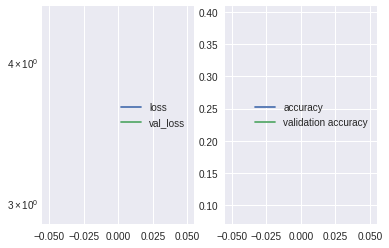

Epoch 2/30
8000/8000 [==============================] - 83s 10ms/step - loss: 2.7627 - acc: 0.3449 - val_loss: 1.4747 - val_acc: 0.6193


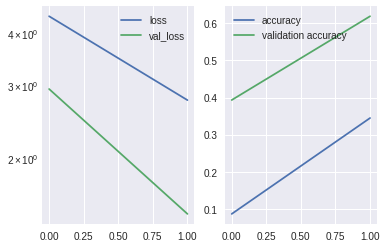

Epoch 3/30
8000/8000 [==============================] - 83s 10ms/step - loss: 1.8297 - acc: 0.5146 - val_loss: 1.1650 - val_acc: 0.6656


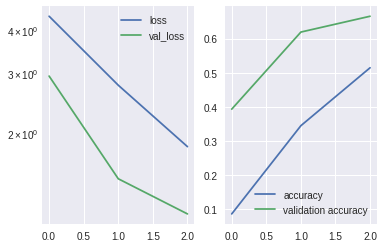

Epoch 4/30
8000/8000 [==============================] - 83s 10ms/step - loss: 1.4150 - acc: 0.6068 - val_loss: 1.0388 - val_acc: 0.6976


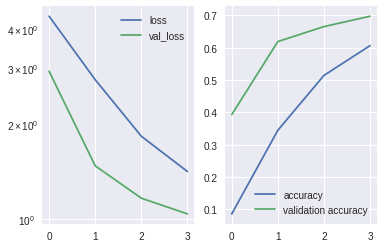

Epoch 5/30
8000/8000 [==============================] - 83s 10ms/step - loss: 1.2328 - acc: 0.6479 - val_loss: 1.0071 - val_acc: 0.7021


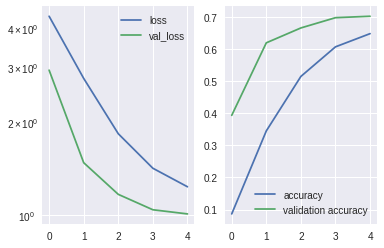

Epoch 6/30
8000/8000 [==============================] - 83s 10ms/step - loss: 1.1158 - acc: 0.6754 - val_loss: 0.9800 - val_acc: 0.7088


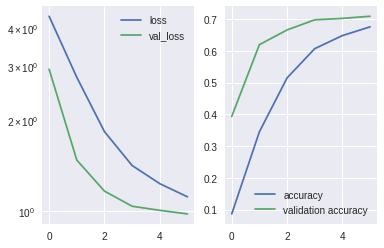

Epoch 7/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.9862 - acc: 0.7045 - val_loss: 0.9648 - val_acc: 0.7228


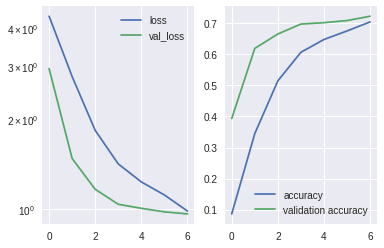

Epoch 8/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.8968 - acc: 0.7228 - val_loss: 0.9459 - val_acc: 0.7237


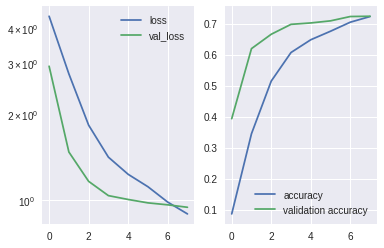

Epoch 9/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.8525 - acc: 0.7395 - val_loss: 0.9477 - val_acc: 0.7241


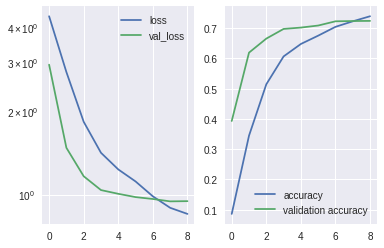

Epoch 10/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.8193 - acc: 0.7528 - val_loss: 0.9372 - val_acc: 0.7349


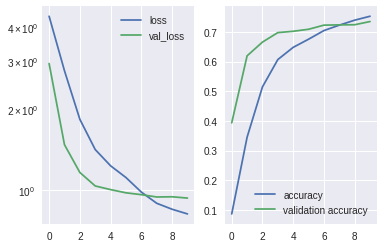

Epoch 11/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.7530 - acc: 0.7649 - val_loss: 0.9580 - val_acc: 0.7295


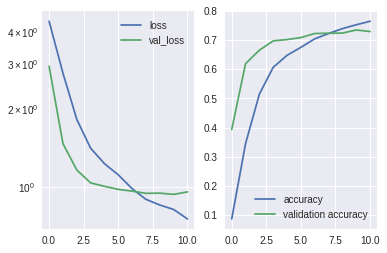

Epoch 12/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.7230 - acc: 0.7824 - val_loss: 0.9522 - val_acc: 0.7309


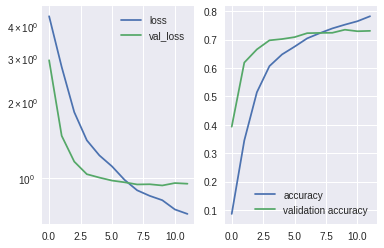

Epoch 13/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.6911 - acc: 0.7850 - val_loss: 0.9555 - val_acc: 0.7349


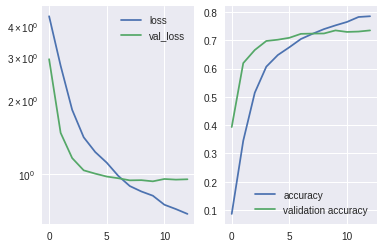

Epoch 14/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.6678 - acc: 0.7914 - val_loss: 0.9617 - val_acc: 0.7363


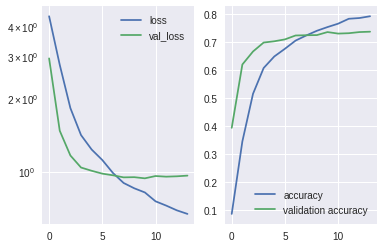

Epoch 15/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.6505 - acc: 0.7994 - val_loss: 0.9267 - val_acc: 0.7367


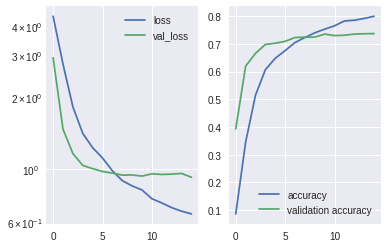

Epoch 16/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.6119 - acc: 0.8121 - val_loss: 0.9542 - val_acc: 0.7430


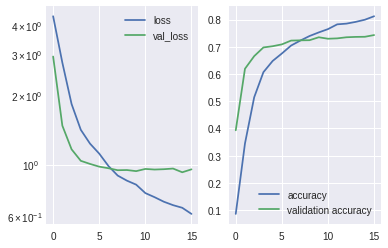

Epoch 17/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.6089 - acc: 0.8103 - val_loss: 0.9482 - val_acc: 0.7426


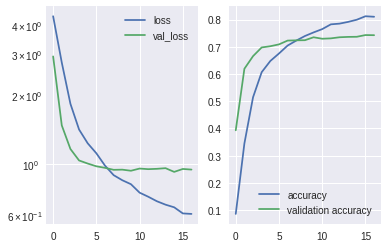

Epoch 18/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.5627 - acc: 0.8239 - val_loss: 0.9765 - val_acc: 0.7340


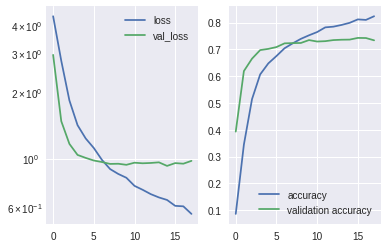

Epoch 19/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.5445 - acc: 0.8274 - val_loss: 0.9823 - val_acc: 0.7372


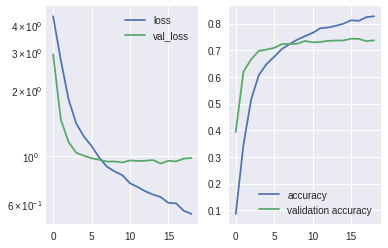

Epoch 20/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.5109 - acc: 0.8390 - val_loss: 0.9687 - val_acc: 0.7408


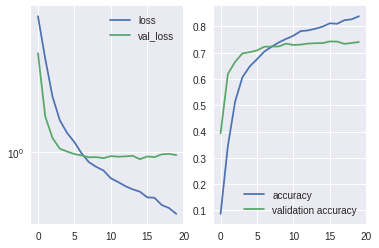

Epoch 21/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.5108 - acc: 0.8370 - val_loss: 0.9773 - val_acc: 0.7408


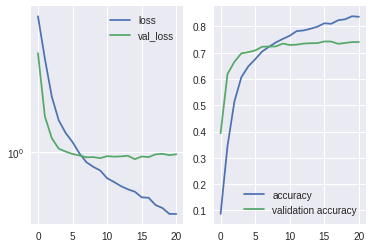

Epoch 22/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4864 - acc: 0.8518 - val_loss: 0.9974 - val_acc: 0.7363


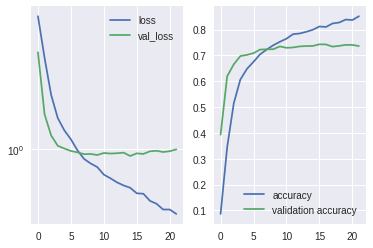

Epoch 23/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4730 - acc: 0.8528 - val_loss: 0.9840 - val_acc: 0.7457


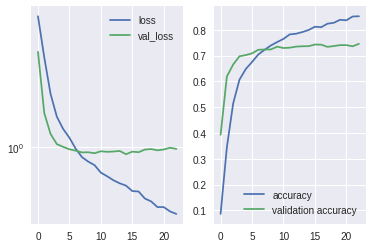

Epoch 24/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4655 - acc: 0.8479 - val_loss: 0.9686 - val_acc: 0.7471


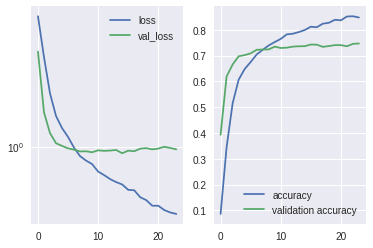

Epoch 25/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4481 - acc: 0.8593 - val_loss: 0.9705 - val_acc: 0.7457


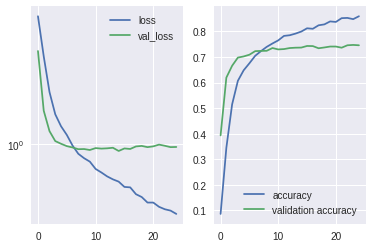

Epoch 26/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4296 - acc: 0.8632 - val_loss: 0.9792 - val_acc: 0.7471


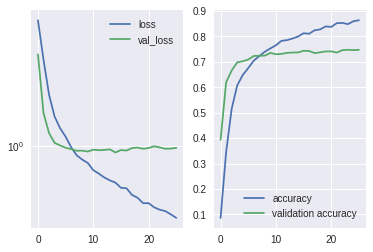

Epoch 27/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4252 - acc: 0.8610 - val_loss: 0.9747 - val_acc: 0.7444


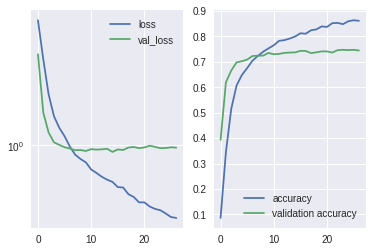

Epoch 28/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.4066 - acc: 0.8731 - val_loss: 1.0026 - val_acc: 0.7453


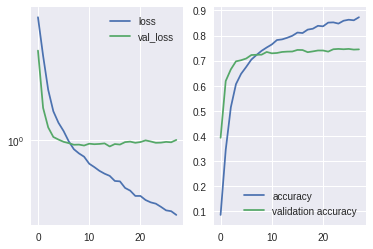

Epoch 29/30
8000/8000 [==============================] - 82s 10ms/step - loss: 0.3909 - acc: 0.8722 - val_loss: 0.9829 - val_acc: 0.7435


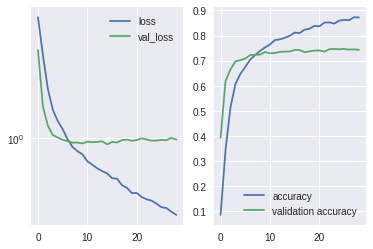

Epoch 30/30
8000/8000 [==============================] - 83s 10ms/step - loss: 0.3862 - acc: 0.8792 - val_loss: 1.0002 - val_acc: 0.7417


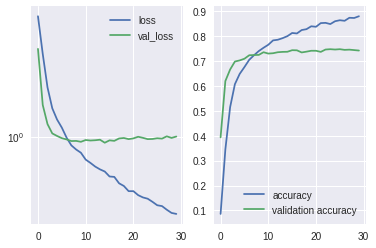

In [52]:
history=model.fit(trainImages, trainLabels1,
          batch_size=64,
          epochs=30,verbose= 1,
          validation_data=(valImages, valLabels1),callbacks = [PlotLearning(), modelCheckpointer])

In [20]:
!pip install h5py

In [0]:
# testImages = np.load('/content/drive/My Drive/Colab Notebooks/testImages.npy')
# print('testImages loaded')

In [0]:
model.save_weights("/content/drive/My Drive/Colab Notebooks/modelInceptionV2.h5")
# predictions = model.predict_proba(tes)

In [0]:
model.load_weights("/content/drive/My Drive/resnoet50model.hdf5")

## Model Testing

Predict the image classes in the testImages array.

In [0]:
y_pred = model.predict(testImages)

## Generating the Submission File

I am reading the test images names and making the submission.csv, using the predictions given by the model, file to submit on kaggle.

In [15]:
print(y_pred.shape)
testname = pd.read_csv('/content/drive/My Drive/testnames.csv')
testname = np.array(testname)
print(testname.shape)
final = np.column_stack((testname, y_pred))

result = pd.DataFrame(columns=classes, data=final)
result.to_csv(path_or_buf='/content/drive/My Drive/submission1.csv', index=False)

(10357, 120)
(10357, 1)


## Summary

The notebook's task was to classify the dog images in to one of the 120 dog class. The notebooks shows the experiment done while completing the task. I experimented with the basic handmade convolutional model, then we moved onto the classical deep learning models like VGG16, VGG19, ResNet50, ResNet101, InceptionV3, InceptionResNetV2 model to classify the images. I also tried to experiment with an ensemble model but, because of the computational limitation was not able to run the model. I also experimented with normal logistic regressor and SVM classifier. I extracted bottleneck features from the classical deep learning models fed those to SVM classifier. Out of all these experiments the ResNet50 with unfreezed 4 layers, that is the current model, performed best for me. I attained the validation accuracy of 74%.

## Conclusion:
The notebook was able to classify the breed of the dog with the test data log_loss of 0.9529. The model performed efficiently on training set with train accuracy of 88% and validation accuracy of 74% with a loss of 0.9502 when the model was trained on 30 epochs. Thus, using ResNet50 model we classified dogs of from one of the 120 classes and attained an accuracy of 74%. 

## Contribution: 
The notebook was able to contribute about 90% and it had also referred to other kernels which helped in leading the competition thus, this contribute to 10%. Overall many new techniques were performed by reviewing and understanding the knowledge shared on internet. In this way, through knowledge transfer I hope my notebook contributes to the better understanding of the data science concepts.

## Citations: 

[1] Kaggle Competition: https://www.kaggle.com/c/dog-breed-identification

[2] Keras Application Documentation: https://keras.io/applications/

[3] SkLearn:  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

[4] Keras preprocessing: https://keras.io/preprocessing/image/

[5] YouTube Link for CNN, Deep Learning: https://www.youtube.com/channel/UCcIXc5mJsHVYTZR1maL5l9w


## License 

Copyright(c) 2019 JINAL SAPARIYA


Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.